In [50]:
### imports

import keras
import numpy as np
import pandas as pd
from scipy import stats
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import uproot
import awkward as ak
from tqdm.notebook import tqdm

In [51]:
# latex settings block

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.numpoints": 1,
    "axes.linewidth": 2,
    "legend.title_fontsize": 18,
    "axes.labelsize": 18,
    "legend.fontsize": 16
})

In [52]:
with np.load("root_files/subjettiness_and_impact_parameter_train.npz") as file:
    feature_array = file['features']
    label_array = file['labels']
    features = file['names'].tolist()
    
nfeatures = len(features)
nlabels = 2

In [53]:
df = pd.DataFrame(feature_array, columns=features)
bkg = df[label_array[:,0]==1]
sig = df[label_array[:,1]==1]

In [54]:
del feature_array, label_array

In [55]:
with np.load("root_files/subjettiness_and_impact_parameter_test.npz") as file:
    feature_array_test = file['features']
    label_array_test = file['labels']

In [56]:
df_test = pd.DataFrame(feature_array_test, columns=features)
bkg_test = df_test[label_array_test[:,0]==1]
sig_test = df_test[label_array_test[:,1]==1]

In [57]:
del feature_array_test, label_array_test

In [58]:
sig_train_out = sig
bkg_train_out = bkg
sig_test_out = sig_test
bkg_test_out = bkg_test

In [59]:
print(bkg.shape)
print(bkg_train_out.shape)
print(bkg_test.shape)
print(bkg_test_out.shape)

(11734326, 31)
(11734326, 31)
(1467277, 31)
(1467277, 31)


In [60]:
del bkg, sig, bkg_test, sig_test, df

In [61]:
bkg_train_out = bkg_train_out.sample(len(sig_train_out)).reset_index(drop=True)
bkg_test_out = bkg_test_out.sample(len(sig_test_out)).reset_index(drop=True)

In [62]:
print(bkg_train_out.shape)
print(sig_train_out.shape)
print(bkg_test_out.shape)
print(sig_test_out.shape)

(1782913, 31)
(1782913, 31)
(222732, 31)
(222732, 31)


  0%|          | 0/30 [00:00<?, ?it/s]

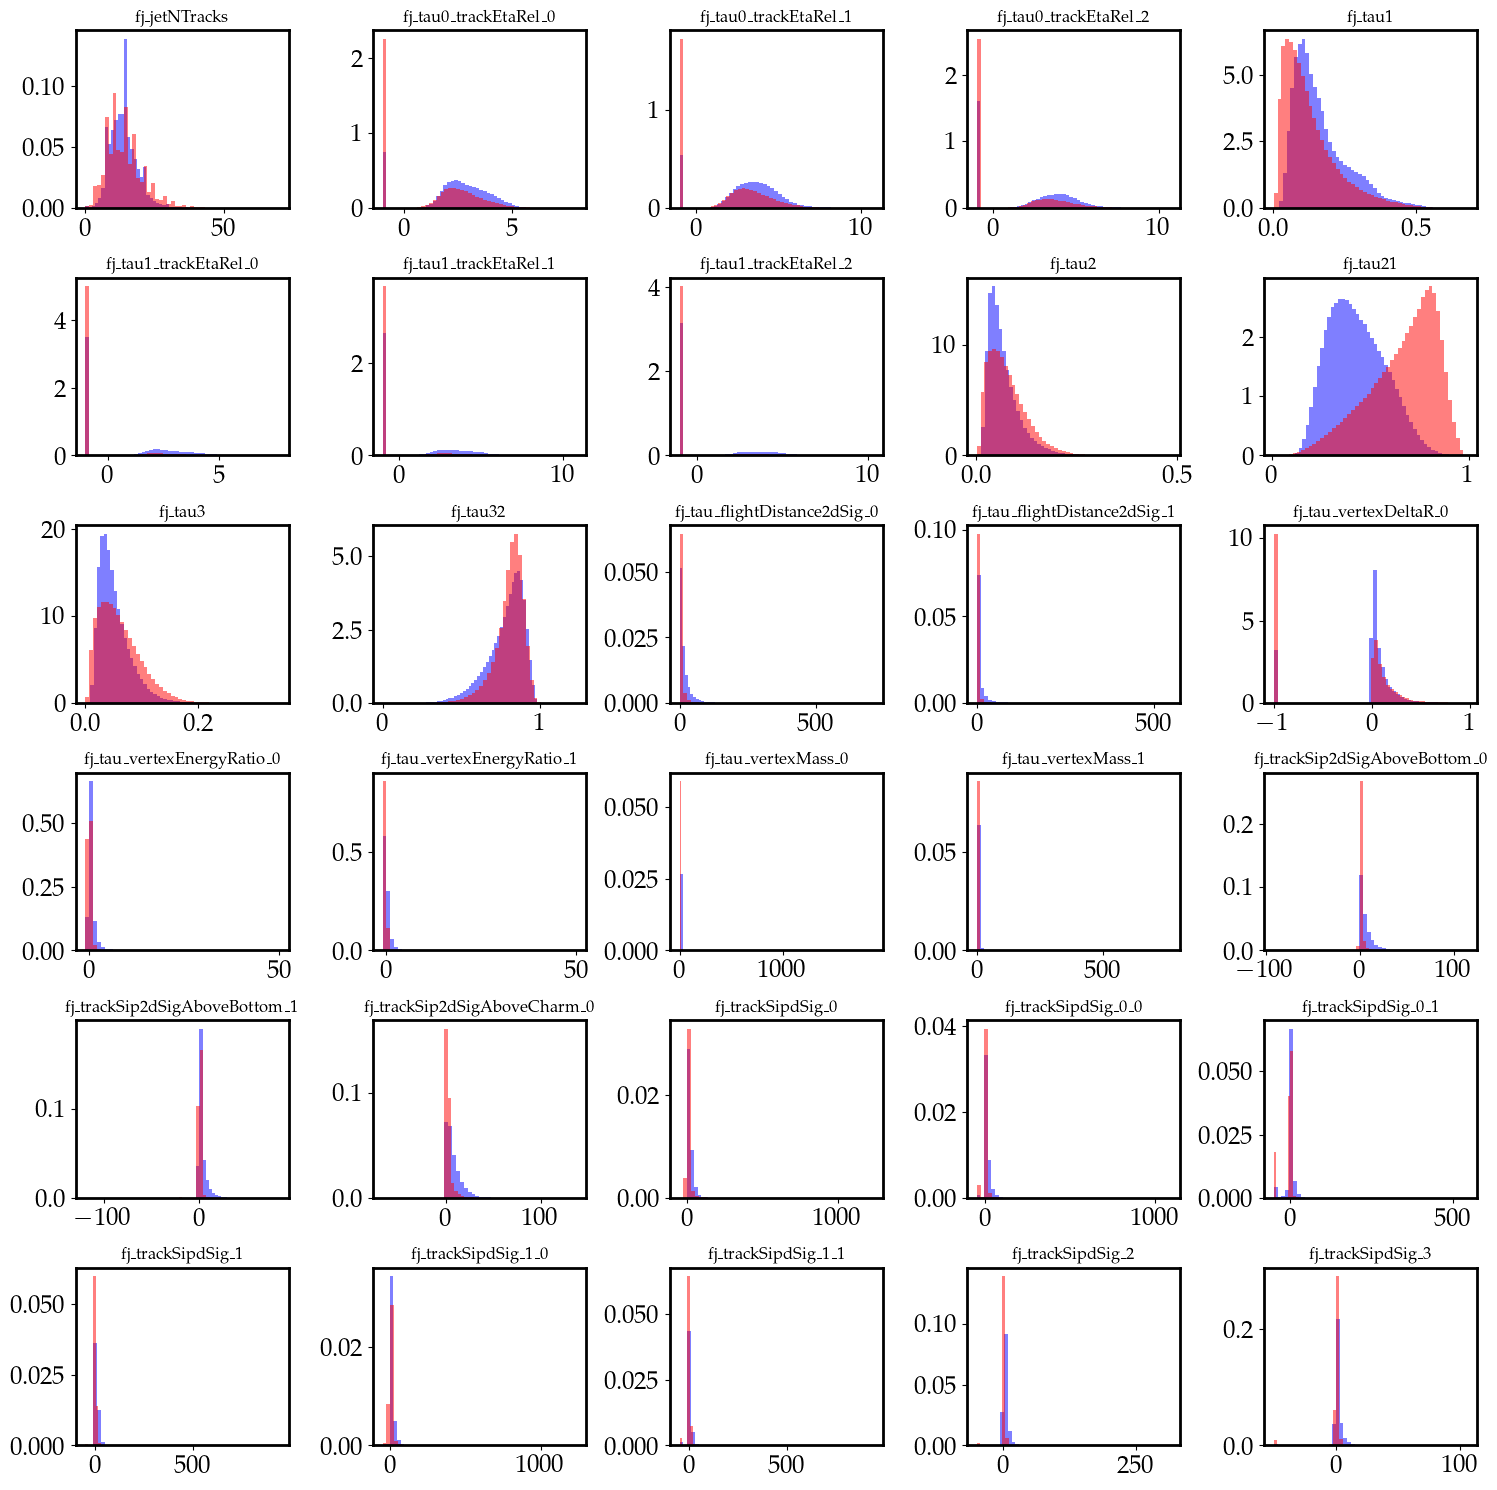

In [63]:
fig, axes = plt.subplots(6,5, figsize=(15,15))

for ax, label in tqdm(zip(axes.ravel(), sig_train_out.columns.drop('fj_nSV')), total = 30):
    ax.hist(sig_train_out[label],density=True,color='b',alpha=0.5,bins=50)
    ax.hist(bkg_train_out[label],density=True,color='r',alpha=0.5,bins=50)
    ax.set_title(label)

plt.tight_layout()
plt.show()

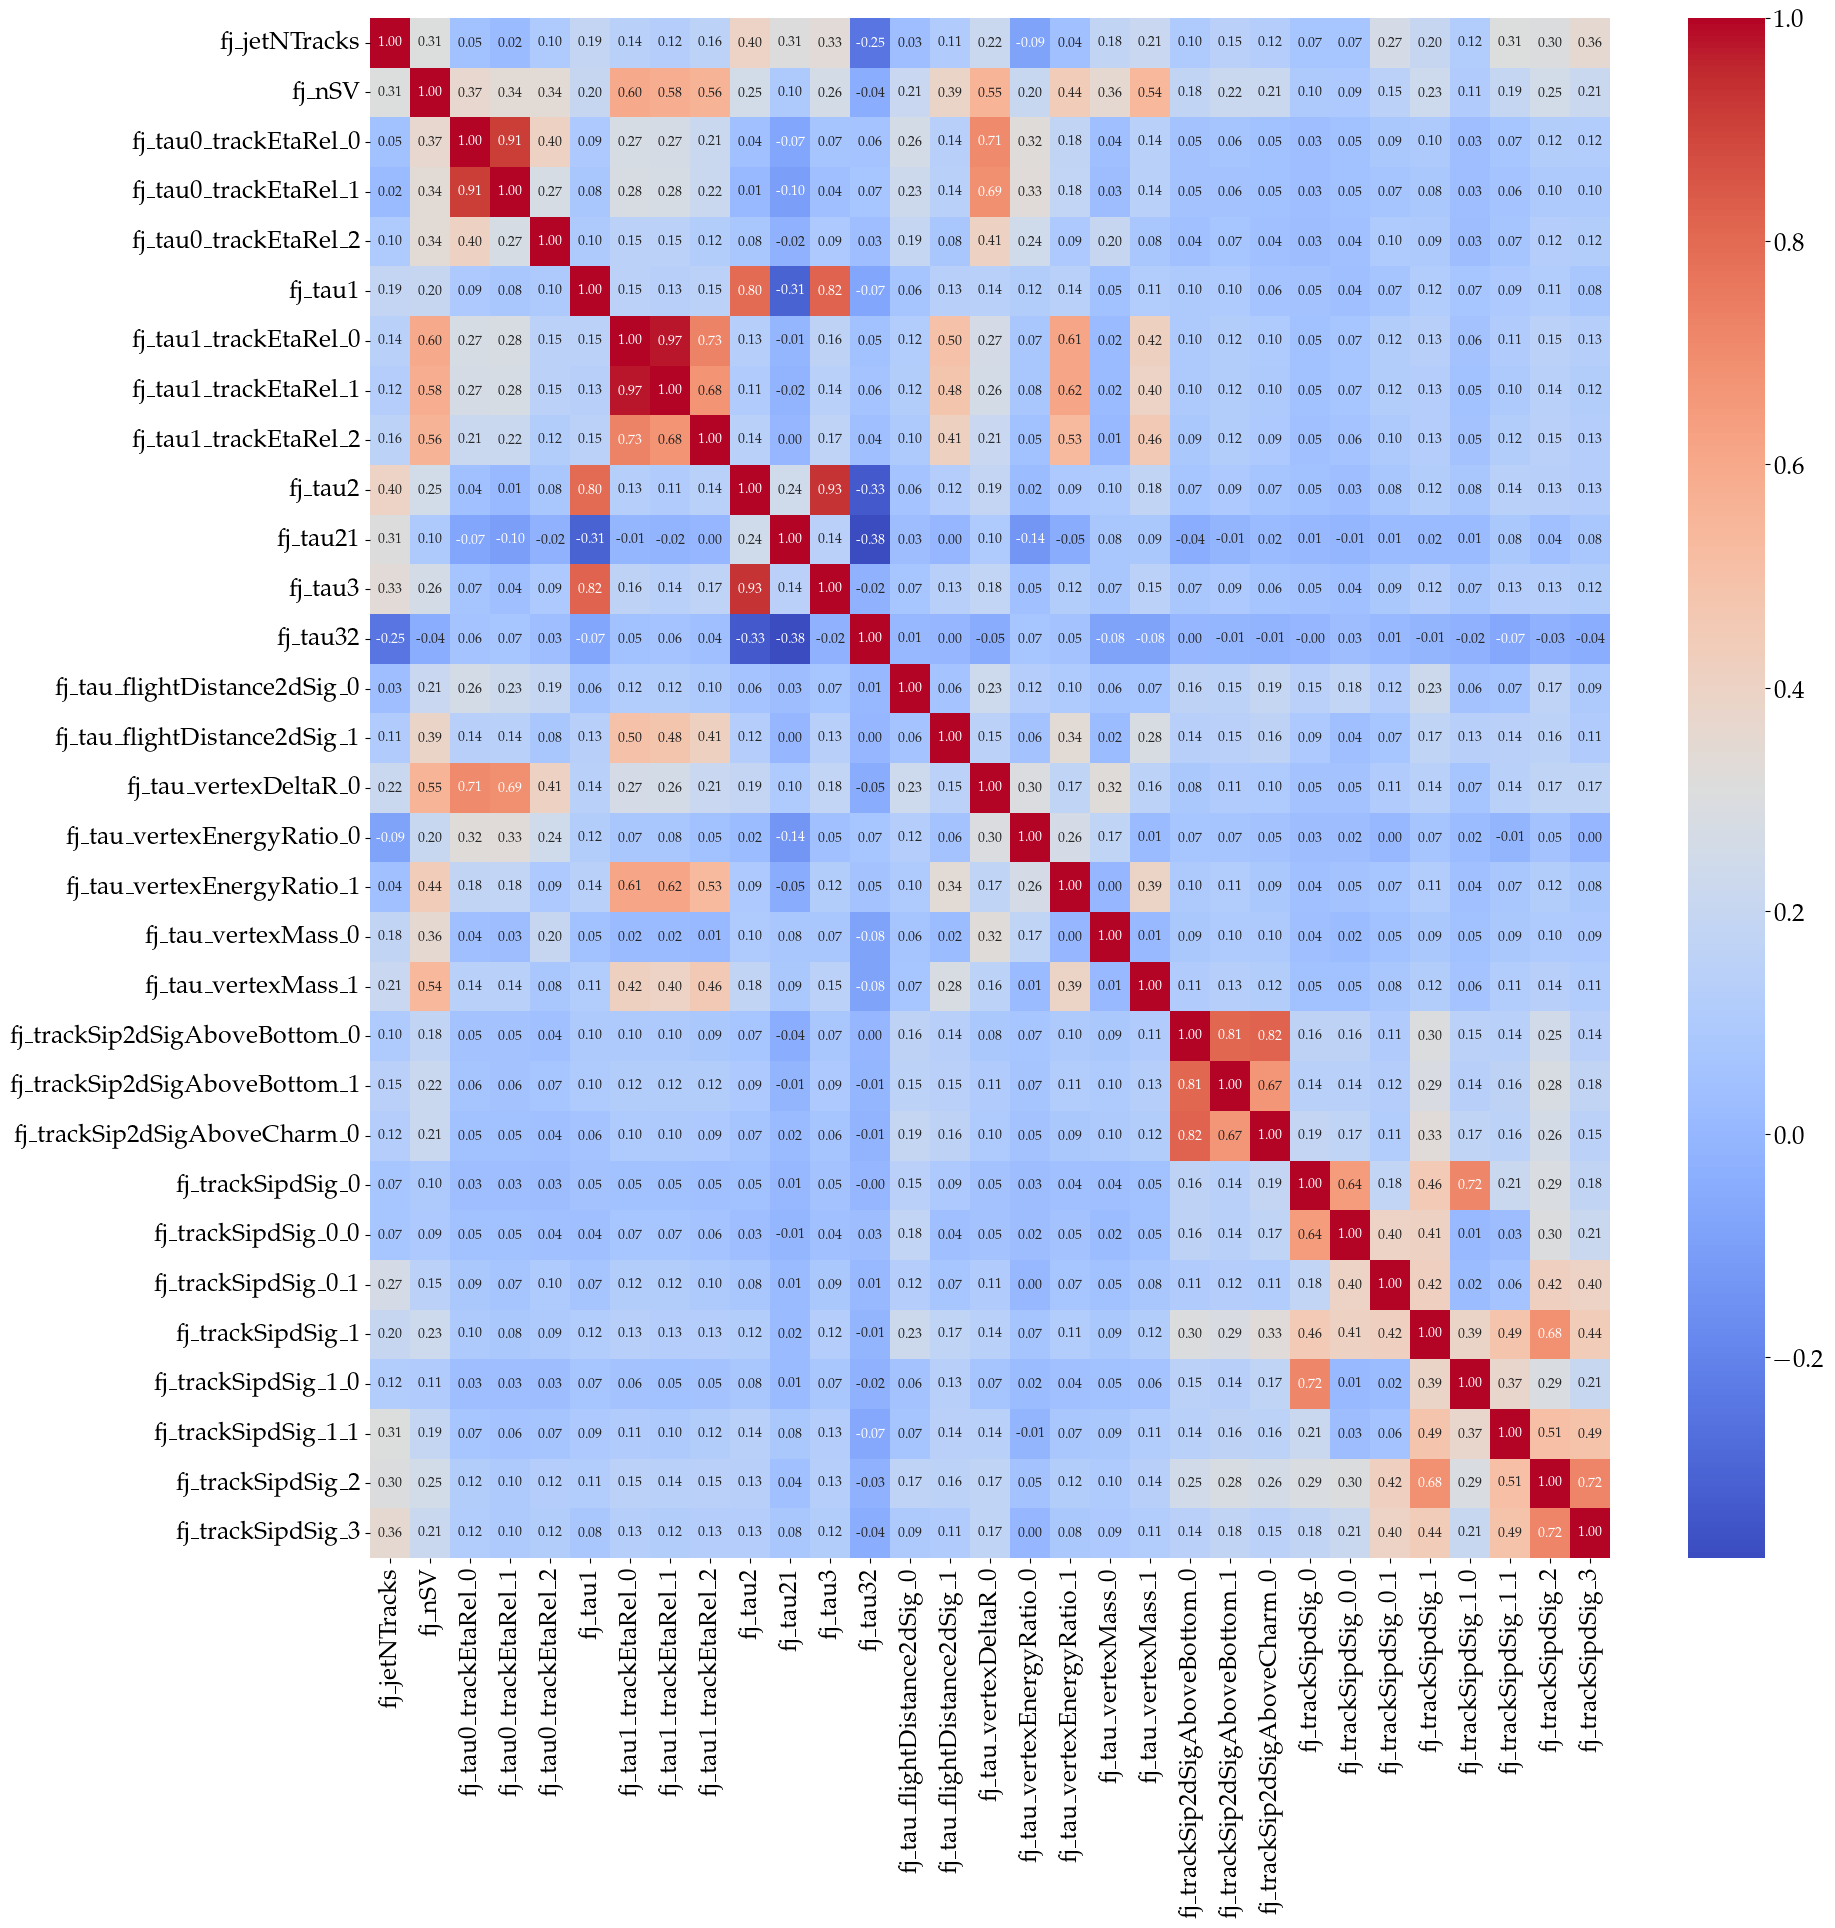

In [64]:
plt.figure(figsize=(20,20))
sns.heatmap(sig_train_out.corr(), cmap='coolwarm',annot=True, fmt='.2f')
plt.show()

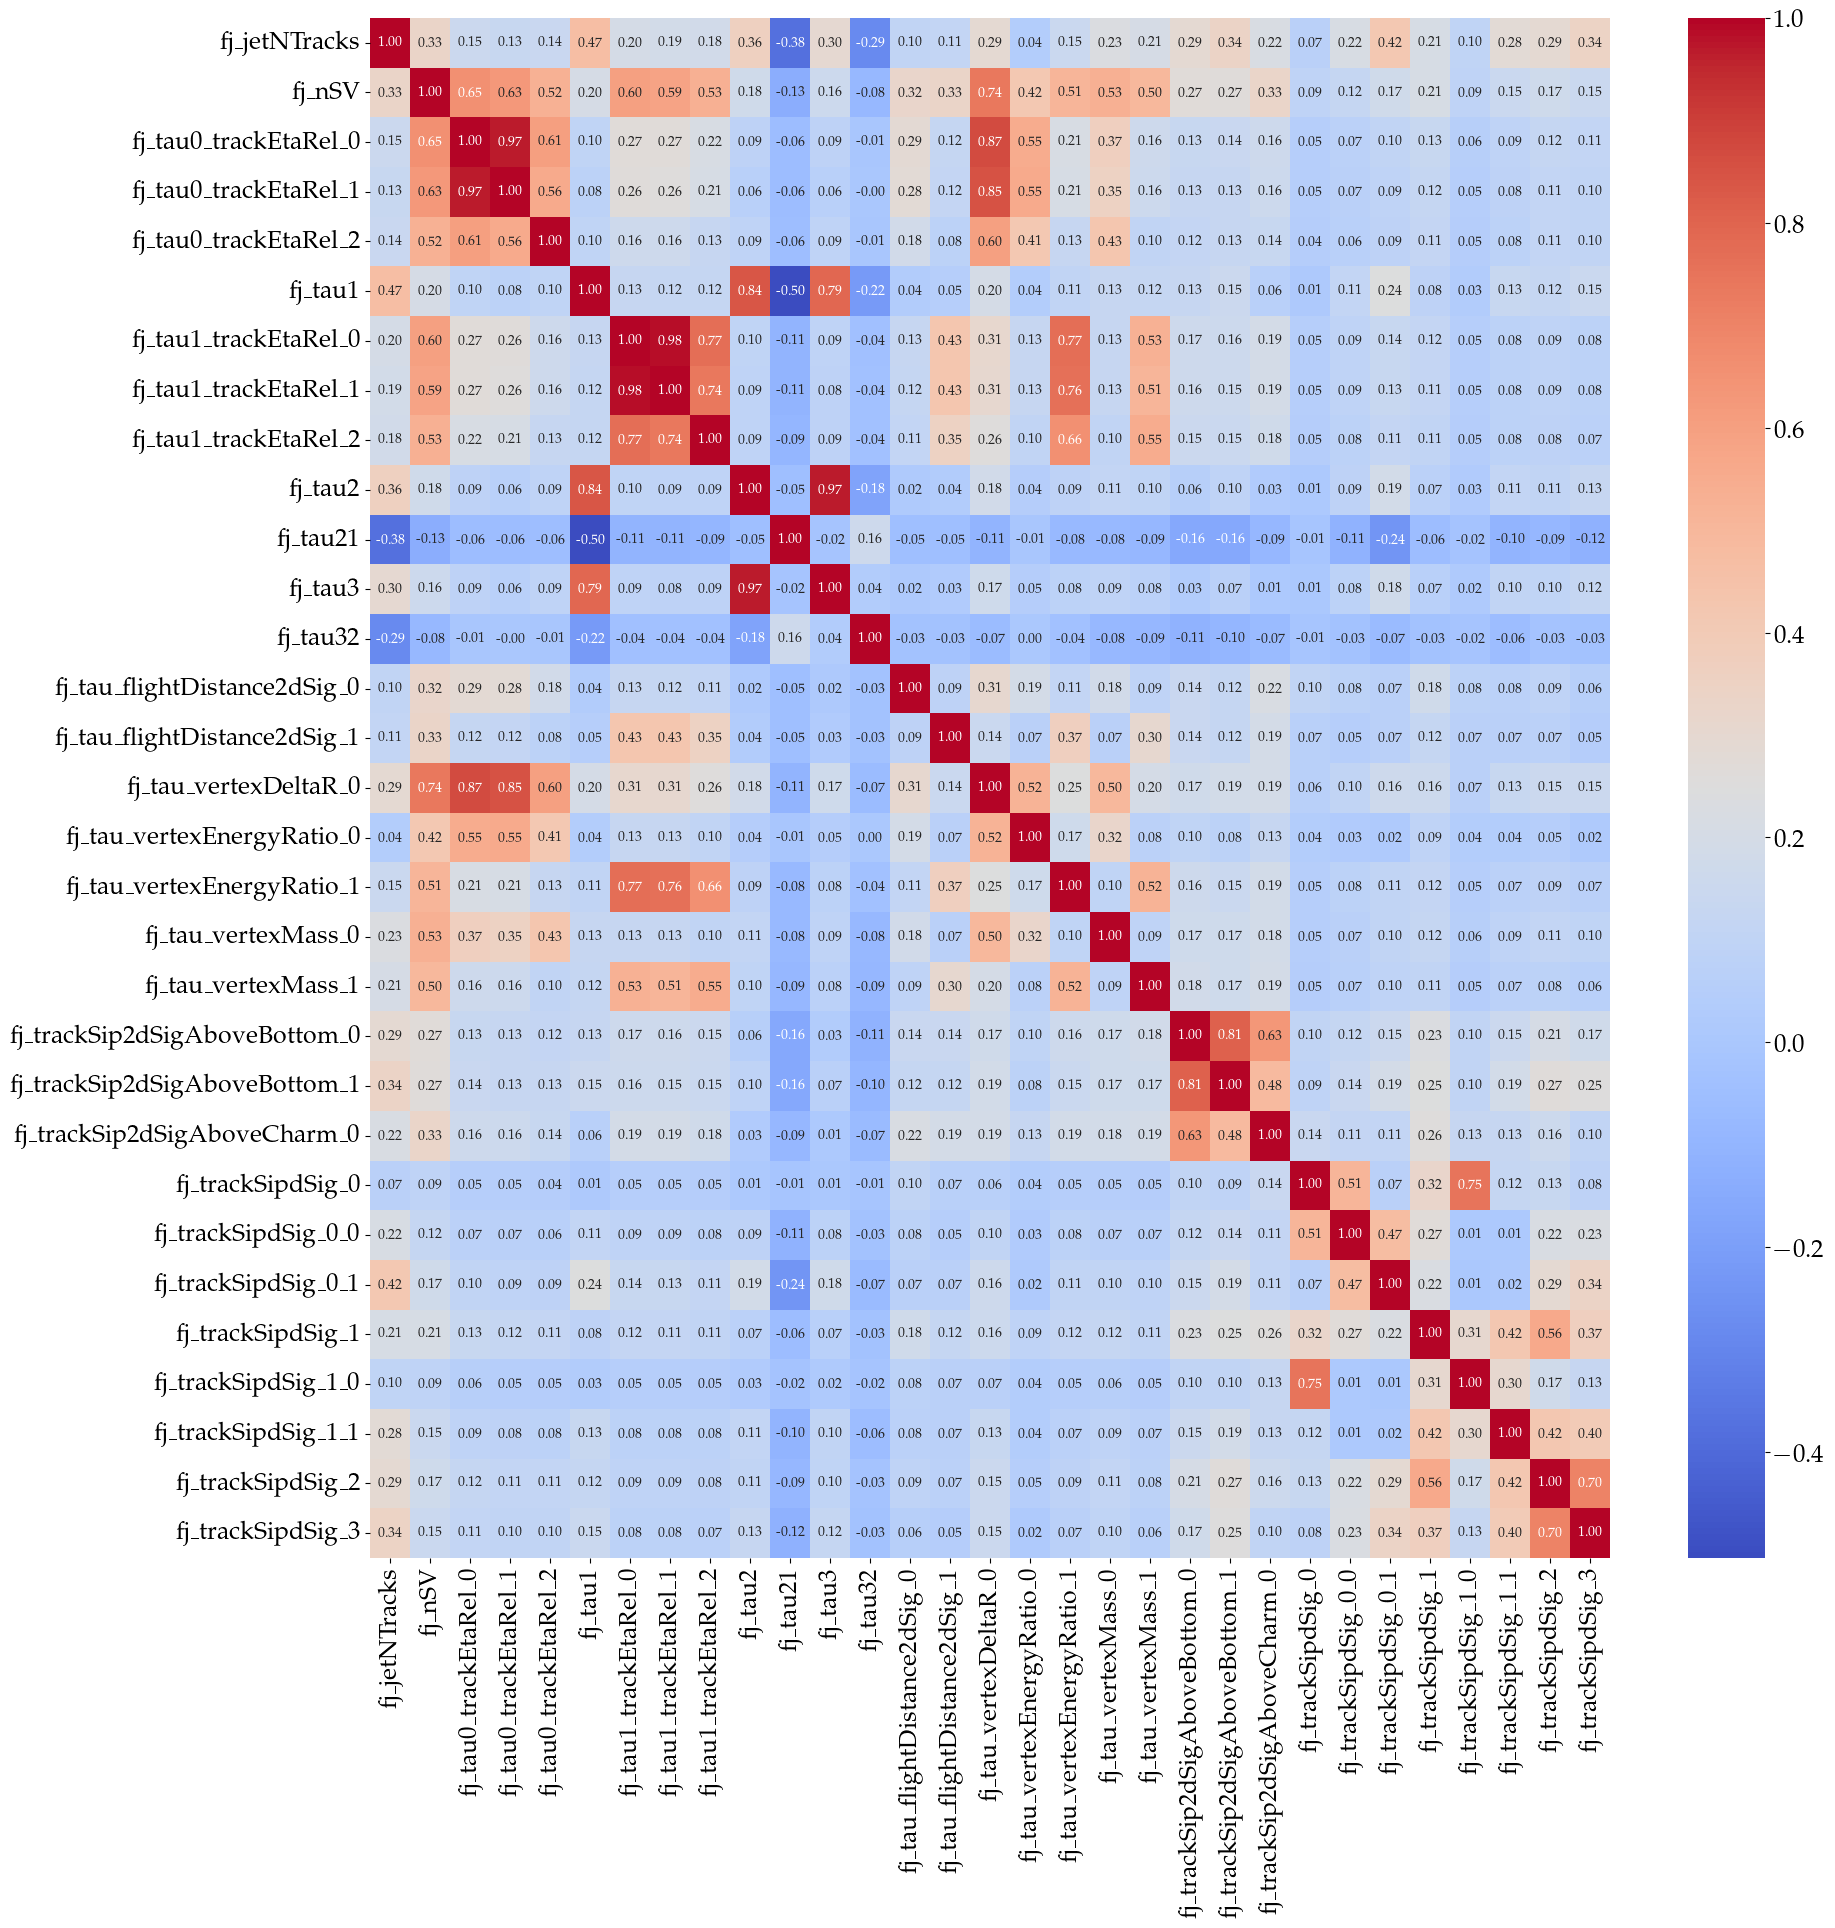

In [65]:
plt.figure(figsize=(20,20))
sns.heatmap(bkg_train_out.corr(), cmap='coolwarm',annot=True, fmt='.2f')
plt.show()

In [66]:
hbb = np.concatenate((np.ones(len(sig_train_out)),np.zeros(len(bkg_train_out))), axis=None)
QCD = np.concatenate((np.zeros(len(sig_train_out)),np.ones(len(bkg_train_out))), axis=None)
traindata = pd.concat([sig_train_out, bkg_train_out])
traindata['hbb'] = hbb
traindata['QCD'] = QCD

train = traindata.sample(frac=1).reset_index(drop=True)
X_train = train.iloc[:,:-2]
y_train = train.iloc[:,-2:]

In [67]:
del traindata

In [68]:
hbb = np.concatenate((np.ones(len(sig_test_out)),np.zeros(len(bkg_test_out))), axis=None)
QCD = np.concatenate((np.zeros(len(sig_test_out)),np.ones(len(bkg_test_out))), axis=None)
testdata = pd.concat([sig_test_out, bkg_test_out])
testdata['hbb'] = hbb
testdata['QCD'] = QCD

test = testdata.sample(frac=1).reset_index(drop=True)
X_test = test.iloc[:,:-2]
y_test = test.iloc[:,-2:]

In [69]:
del testdata

In [71]:
%%time
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_train = pd.DataFrame(X_train)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test)

CPU times: user 371 ms, sys: 155 ms, total: 526 ms
Wall time: 525 ms


In [73]:
eigenvalues, eigenvectors = np.linalg.eig(X_train.cov())

In [74]:
idx = eigenvalues.argsort()[::-1]   
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

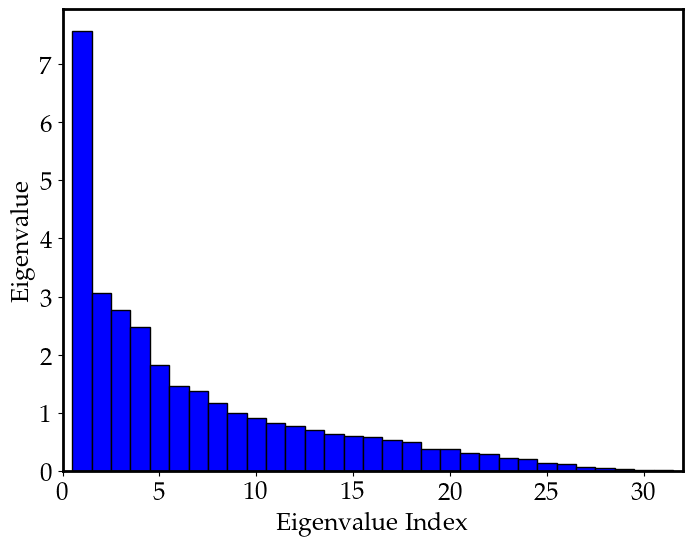

In [75]:
plt.figure(figsize=(8,6))
x = np.arange(1,nfeatures+1)
plt.xlim(0,nfeatures+1)
plt.bar(x,eigenvalues,color='b',width=1,edgecolor='k')
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue')
plt.show()

In [76]:
%%time
pca = PCA()
pca.fit(X_train)
print(pca.explained_variance_ratio_)
print(np.cumsum(pca.explained_variance_ratio_))
print(pca.singular_values_)

[0.24406937 0.09865963 0.08933003 0.08008049 0.05858661 0.04737689
 0.04429702 0.0376746  0.03216491 0.02945775 0.02658436 0.0248229
 0.02267447 0.02027353 0.0195496  0.01889291 0.01728611 0.01594738
 0.0123992  0.01195656 0.01020001 0.00970051 0.00696528 0.00667499
 0.0045899  0.00384204 0.00213582 0.00143786 0.00139334 0.00058449
 0.00039145]
[0.24406937 0.34272901 0.43205904 0.51213952 0.57072613 0.61810303
 0.66240005 0.70007465 0.73223956 0.7616973  0.78828166 0.81310456
 0.83577904 0.85605256 0.87560216 0.89449507 0.91178117 0.92772856
 0.94012776 0.95208433 0.96228434 0.97198484 0.97895012 0.98562511
 0.99021501 0.99405704 0.99619287 0.99763072 0.99902406 0.99960855
 1.        ]
[5194.18679166 3302.40757149 3142.38692914 2975.2555121  2544.83781163
 2288.46464442 2212.8306638  2040.7286198  1885.61091121 1804.51573981
 1714.24936919 1656.48386259 1583.17713644 1497.01296422 1470.04225227
 1445.14145523 1382.32291788 1327.7173626  1170.73291331 1149.64598221
 1061.84526367 1035.5

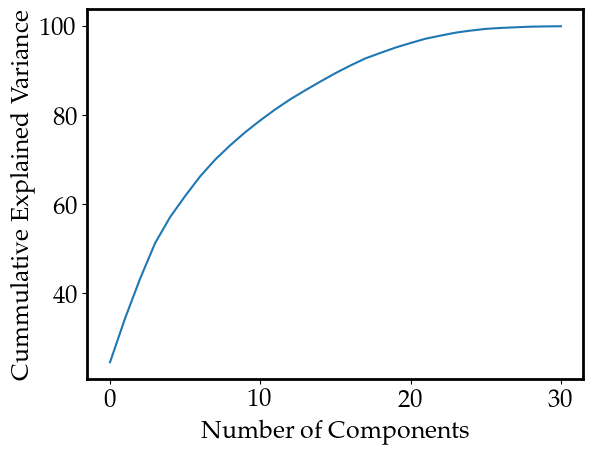

In [77]:
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.xlabel('Number of Components')
plt.ylabel('Cummulative Explained Variance')
plt.show()

In [78]:
def KL(feature1 ,feature2 , bins = 100, eps = 1e-8):
    low, high = (np.min([np.min(feature1),np.min(feature2)]), np.max([np.max(feature1),np.max(feature2)]))
    pk, bins = np.histogram(feature1, bins=bins, range=(low,high))
    qk, bins = np.histogram(feature2, bins=bins, range=(low,high))
    pk = pk + eps
    qk = qk + eps
    D1 = stats.entropy(pk, qk)
    D2 = stats.entropy(qk, pk)
    divergence = D1 + D2
    return divergence

In [79]:
div = []
for i in tqdm(features):
    divergence = KL(sig_train_out[i], bkg_train_out[i])
    div.append(divergence)
divergences = pd.Series(div, index=features).sort_values(ascending=False)
print(divergences)

  0%|          | 0/31 [00:00<?, ?it/s]

fj_tau21                         2.226795
fj_trackSip2dSigAboveBottom_0    1.405128
fj_trackSip2dSigAboveCharm_0     1.171740
fj_trackSip2dSigAboveBottom_1    1.042307
fj_tau_flightDistance2dSig_0     0.858307
fj_trackSipdSig_0_0              0.813850
fj_tau_vertexEnergyRatio_0       0.758566
fj_trackSipdSig_0                0.722900
fj_nSV                           0.705238
fj_tau_vertexDeltaR_0            0.599454
fj_tau_vertexEnergyRatio_1       0.596655
fj_trackSipdSig_0_1              0.595053
fj_trackSipdSig_1                0.586650
fj_tau1                          0.556723
fj_trackSipdSig_2                0.555100
fj_tau0_trackEtaRel_1            0.491288
fj_tau0_trackEtaRel_0            0.490925
fj_tau_flightDistance2dSig_1     0.450883
fj_tau1_trackEtaRel_1            0.439671
fj_tau1_trackEtaRel_0            0.437872
fj_trackSipdSig_3                0.394573
fj_tau1_trackEtaRel_2            0.313340
fj_trackSipdSig_1_0              0.312129
fj_tau0_trackEtaRel_2            0

In [80]:
# X_train_final = pd.DataFrame(pca.transform(X_train)).iloc[:,:20]
# X_test_final =  pd.DataFrame(pca.transform(X_test)).iloc[:,:20]
X_train_final = X_train
X_test_final =  X_test

In [81]:
def make_ks_plot(y_train, train_proba, y_test, test_proba, bins=30, fig_sz=(10, 8)):
    '''
    OUTPUT: outputs KS test/train overtraining plots for classifier output
    INPUTS:
        y_train - Series with outputs of model
        train_proba - np.ndarray from sklearn predict_proba(). Same shape as y_train. 0-1 probabilities from model.
        y_test - Series with outputs of model
        test_proba - np.ndarray from sklearn predict_proba(). Same shape as y_test. 0-1 probabilities from model.
        bins - number of bins for viz. Default 30.
        fig_sz - change to True in order to get larger outputs. Default False.
    '''

    train = pd.DataFrame(y_train, columns=["label"])
    test = pd.DataFrame(y_test, columns=["label"])
    train["probability"] = train_proba
    test["probability"] = test_proba
    
    decisions = []
    for df in [train, test]:
        d1 = df['probability'][df["label"] == 1]
        d2 = df['probability'][df["label"] == 0]
        decisions += [d1, d2]

    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (0,1)

    fig = plt.figure(figsize=fig_sz)
    
    train_pos = plt.hist(decisions[0],
         color='b', alpha=0.5, range=low_high, bins=bins,
         histtype='stepfilled', density=True,
         label='Signal (test)')

    train_neg = plt.hist(decisions[1],
         color='r', alpha=0.5, range=low_high, bins=bins,
         histtype='stepfilled', density=True,
         label='Background (test)')

    hist, bins = np.histogram(decisions[2],
                          bins=bins, range=low_high, density=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    test_pos = plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='Signal (train)')

    hist, bins = np.histogram(decisions[3],
                          bins=bins, range=low_high, density=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    test_neg = plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='Background (train)')

    # get the KS score
    ks = stats.ks_2samp(decisions[0], decisions[2])

    plt.xlabel("Classifier Output", fontsize=12)
    plt.ylabel("Arbitrary Normalized Units", fontsize=12)

    plt.xlim(0, 1)
    plt.plot([], [], ' ', label='KS Statistic (p-value): '+str(round(ks[0],3))+' ('+str(round(ks[1],3))+')')
    plt.legend(loc='upper center', fontsize=12)
    plt.tight_layout()
    plt.close()
    return fig

In [82]:
# build a simple neural network in keras

keras_model = keras.Sequential()
keras_model.add(BatchNormalization(input_shape=(X_train_final.shape[1],)))
keras_model.add(Dense(units=60,activation='relu',input_dim=X_train_final.shape[1]))
keras_model.add(Dense(units=60,activation='relu'))
keras_model.add(Dense(units=2,activation='softmax'))
keras_model.save_weights('random_weights.h5')
print(keras_model.summary())

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_18 (Bat  (None, 31)               124       
 chNormalization)                                                
                                                                 
 dense_61 (Dense)            (None, 60)                1920      
                                                                 
 dense_62 (Dense)            (None, 60)                3660      
                                                                 
 dense_63 (Dense)            (None, 2)                 122       
                                                                 
Total params: 5,826
Trainable params: 5,764
Non-trainable params: 62
_________________________________________________________________
None


In [84]:
losses = []
rates = np.logspace(-3,0,100)

for lr in tqdm(rates):
    keras_model.load_weights('random_weights.h5')
    opt = keras.optimizers.SGD(learning_rate=lr)
    keras_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    history = keras_model.fit(X_train_final.to_numpy(), y_train.to_numpy(), batch_size=2**16, epochs=10,
                              shuffle=False)
    losses.append(history.history['loss'][-1])

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/10
55/55 [==============================] - 1s 15ms/step - loss: 0.7327 - accuracy: 0.5755
Epoch 2/10
55/55 [==============================] - 1s 15ms/step - loss: 0.7029 - accuracy: 0.5979
Epoch 3/10
55/55 [==============================] - 1s 15ms/step - loss: 0.6785 - accuracy: 0.6171
Epoch 4/10
55/55 [==============================] - 1s 15ms/step - loss: 0.6581 - accuracy: 0.6346
Epoch 5/10
55/55 [==============================] - 1s 15ms/step - loss: 0.6406 - accuracy: 0.6512
Epoch 6/10
55/55 [==============================] - 1s 14ms/step - loss: 0.6252 - accuracy: 0.6674
Epoch 7/10
55/55 [==============================] - 1s 15ms/step - loss: 0.6115 - accuracy: 0.6828
Epoch 8/10
55/55 [==============================] - 1s 14ms/step - loss: 0.5992 - accuracy: 0.6972
Epoch 9/10
55/55 [==============================] - 1s 14ms/step - loss: 0.5880 - accuracy: 0.7099
Epoch 10/10
55/55 [==============================] - 1s 15ms/step - loss: 0.5777 - accuracy: 0.7212
Epoch 1/1

55/55 [==============================] - 1s 15ms/step - loss: 0.5423 - accuracy: 0.7527
Epoch 6/10
55/55 [==============================] - 1s 15ms/step - loss: 0.5218 - accuracy: 0.7663
Epoch 7/10
55/55 [==============================] - 1s 15ms/step - loss: 0.5044 - accuracy: 0.7762
Epoch 8/10
55/55 [==============================] - 1s 15ms/step - loss: 0.4892 - accuracy: 0.7840
Epoch 9/10
55/55 [==============================] - 1s 15ms/step - loss: 0.4757 - accuracy: 0.7906
Epoch 10/10
55/55 [==============================] - 1s 16ms/step - loss: 0.4637 - accuracy: 0.7966
Epoch 1/10
55/55 [==============================] - 1s 14ms/step - loss: 0.7021 - accuracy: 0.5990
Epoch 2/10
55/55 [==============================] - 1s 14ms/step - loss: 0.6352 - accuracy: 0.6575
Epoch 3/10
55/55 [==============================] - 1s 14ms/step - loss: 0.5921 - accuracy: 0.7051
Epoch 4/10
55/55 [==============================] - 1s 14ms/step - loss: 0.5603 - accuracy: 0.7379
Epoch 5/10
55/55 [==

55/55 [==============================] - 1s 15ms/step - loss: 0.3679 - accuracy: 0.8446
Epoch 10/10
55/55 [==============================] - 1s 17ms/step - loss: 0.3608 - accuracy: 0.8475
Epoch 1/10
55/55 [==============================] - 1s 17ms/step - loss: 0.6432 - accuracy: 0.6541
Epoch 2/10
55/55 [==============================] - 1s 16ms/step - loss: 0.5355 - accuracy: 0.7563
Epoch 3/10
55/55 [==============================] - 1s 14ms/step - loss: 0.4808 - accuracy: 0.7881
Epoch 4/10
55/55 [==============================] - 1s 15ms/step - loss: 0.4439 - accuracy: 0.8068
Epoch 5/10
55/55 [==============================] - 1s 14ms/step - loss: 0.4171 - accuracy: 0.8211
Epoch 6/10
55/55 [==============================] - 1s 14ms/step - loss: 0.3973 - accuracy: 0.8314
Epoch 7/10
55/55 [==============================] - 1s 15ms/step - loss: 0.3827 - accuracy: 0.8382
Epoch 8/10
55/55 [==============================] - 1s 16ms/step - loss: 0.3717 - accuracy: 0.8430
Epoch 9/10
55/55 [==

55/55 [==============================] - 1s 14ms/step - loss: 0.3717 - accuracy: 0.8430
Epoch 4/10
55/55 [==============================] - 1s 15ms/step - loss: 0.3509 - accuracy: 0.8515
Epoch 5/10
55/55 [==============================] - 1s 16ms/step - loss: 0.3390 - accuracy: 0.8564
Epoch 6/10
55/55 [==============================] - 1s 15ms/step - loss: 0.3306 - accuracy: 0.8601
Epoch 7/10
55/55 [==============================] - 1s 16ms/step - loss: 0.3241 - accuracy: 0.8630
Epoch 8/10
55/55 [==============================] - 1s 16ms/step - loss: 0.3188 - accuracy: 0.8655
Epoch 9/10
55/55 [==============================] - 1s 16ms/step - loss: 0.3143 - accuracy: 0.8676
Epoch 10/10
55/55 [==============================] - 1s 15ms/step - loss: 0.3105 - accuracy: 0.8694
Epoch 1/10
55/55 [==============================] - 1s 15ms/step - loss: 0.5471 - accuracy: 0.7371
Epoch 2/10
55/55 [==============================] - 1s 15ms/step - loss: 0.4115 - accuracy: 0.8239
Epoch 3/10
55/55 [==

55/55 [==============================] - 1s 15ms/step - loss: 0.2874 - accuracy: 0.8800
Epoch 8/10
55/55 [==============================] - 1s 15ms/step - loss: 0.2835 - accuracy: 0.8817
Epoch 9/10
55/55 [==============================] - 1s 15ms/step - loss: 0.2804 - accuracy: 0.8831
Epoch 10/10
55/55 [==============================] - 1s 15ms/step - loss: 0.2778 - accuracy: 0.8843
Epoch 1/10
55/55 [==============================] - 1s 15ms/step - loss: 0.4431 - accuracy: 0.8013
Epoch 2/10
55/55 [==============================] - 1s 15ms/step - loss: 0.3368 - accuracy: 0.8574
Epoch 3/10
55/55 [==============================] - 1s 15ms/step - loss: 0.3163 - accuracy: 0.8667
Epoch 4/10
55/55 [==============================] - 1s 15ms/step - loss: 0.3046 - accuracy: 0.8722
Epoch 5/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2965 - accuracy: 0.8760
Epoch 6/10
55/55 [==============================] - 1s 15ms/step - loss: 0.2903 - accuracy: 0.8788
Epoch 7/10
55/55 [==

55/55 [==============================] - 1s 17ms/step - loss: 0.3681 - accuracy: 0.8404
Epoch 2/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2973 - accuracy: 0.8756
Epoch 3/10
55/55 [==============================] - 1s 15ms/step - loss: 0.2821 - accuracy: 0.8824
Epoch 4/10
55/55 [==============================] - 1s 15ms/step - loss: 0.2744 - accuracy: 0.8858
Epoch 5/10
55/55 [==============================] - 1s 15ms/step - loss: 0.2694 - accuracy: 0.8883
Epoch 6/10
55/55 [==============================] - 1s 14ms/step - loss: 0.2656 - accuracy: 0.8901
Epoch 7/10
55/55 [==============================] - 1s 15ms/step - loss: 0.2627 - accuracy: 0.8915
Epoch 8/10
55/55 [==============================] - 1s 15ms/step - loss: 0.2606 - accuracy: 0.8926
Epoch 9/10
55/55 [==============================] - 1s 14ms/step - loss: 0.2592 - accuracy: 0.8932
Epoch 10/10
55/55 [==============================] - 1s 15ms/step - loss: 0.2579 - accuracy: 0.8938
Epoch 1/10
55/55 [==

55/55 [==============================] - 1s 16ms/step - loss: 0.2688 - accuracy: 0.8884
Epoch 6/10
55/55 [==============================] - 1s 15ms/step - loss: 0.2623 - accuracy: 0.8914
Epoch 7/10
55/55 [==============================] - 1s 15ms/step - loss: 0.2618 - accuracy: 0.8917
Epoch 8/10
55/55 [==============================] - 1s 15ms/step - loss: 0.2556 - accuracy: 0.8945
Epoch 9/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2568 - accuracy: 0.8940
Epoch 10/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2508 - accuracy: 0.8967
Epoch 1/10
55/55 [==============================] - 1s 16ms/step - loss: 0.3547 - accuracy: 0.8436
Epoch 2/10
55/55 [==============================] - 1s 15ms/step - loss: 0.2882 - accuracy: 0.8788
Epoch 3/10
55/55 [==============================] - 1s 15ms/step - loss: 0.2792 - accuracy: 0.8832
Epoch 4/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2715 - accuracy: 0.8869
Epoch 5/10
55/55 [==

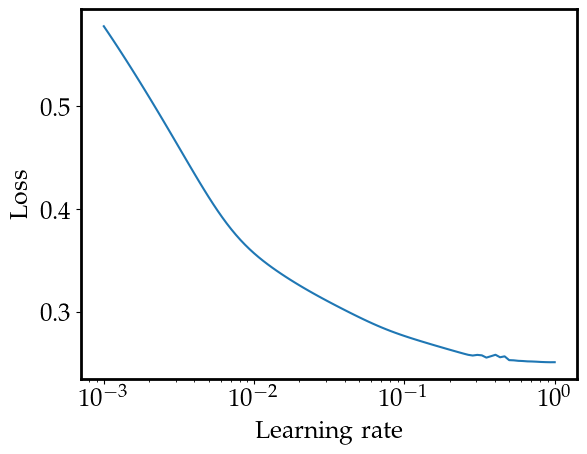

In [85]:
plt.plot(rates, losses)
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.semilogx()
plt.show()

In [86]:
lr = rates[np.nanargmin(losses)]
print(lr)

0.9326033468832199


In [90]:
%%time
# define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint('keras_model_best.h5', monitor='val_loss', save_best_only=True)
callbacks = [early_stopping, model_checkpoint]

# fit keras model
keras_model.load_weights('random_weights.h5')
opt = keras.optimizers.SGD(learning_rate=lr)
keras_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
history = keras_model.fit(X_train_final.to_numpy(), y_train.to_numpy(), batch_size=2**16, 
                          epochs=100, shuffle=False, callbacks = callbacks, 
                          validation_data=(X_test_final,y_test))

Epoch 1/100
55/55 [==============================] - 1s 17ms/step - loss: 0.3525 - accuracy: 0.8452 - val_loss: 0.2887 - val_accuracy: 0.8787
Epoch 2/100
55/55 [==============================] - 1s 17ms/step - loss: 0.2880 - accuracy: 0.8789 - val_loss: 0.2821 - val_accuracy: 0.8820
Epoch 3/100
55/55 [==============================] - 1s 17ms/step - loss: 0.2788 - accuracy: 0.8834 - val_loss: 0.2732 - val_accuracy: 0.8859
Epoch 4/100
55/55 [==============================] - 1s 17ms/step - loss: 0.2709 - accuracy: 0.8872 - val_loss: 0.2727 - val_accuracy: 0.8865
Epoch 5/100
55/55 [==============================] - 1s 17ms/step - loss: 0.2688 - accuracy: 0.8884 - val_loss: 0.2653 - val_accuracy: 0.8899
Epoch 6/100
55/55 [==============================] - 1s 17ms/step - loss: 0.2623 - accuracy: 0.8914 - val_loss: 0.2634 - val_accuracy: 0.8907
Epoch 7/100
55/55 [==============================] - 1s 17ms/step - loss: 0.2618 - accuracy: 0.8917 - val_loss: 0.2581 - val_accuracy: 0.8932
Epoch 

In [91]:
# reload best weights
keras_model.load_weights('keras_model_best.h5')

In [92]:
# run model inference on test data set
predict_array_train = keras_model.predict(X_train_final)
predict_array_test = keras_model.predict(X_test_final)

13921/13921 [==============================] - 4s 263us/step


In [93]:
# create ROC curve
fpr, tpr, threshold = roc_curve(y_test.to_numpy()[:,0], predict_array_test[:,0])

In [94]:
print(keras_model.evaluate(X_train_final,y_train))
print(keras_model.evaluate(X_test_final,y_test))

111433/111433 [==============================] - 35s 311us/step - loss: 0.2347 - accuracy: 0.9040
[0.23470135033130646, 0.9040412902832031]
13921/13921 [==============================] - 4s 316us/step - loss: 0.2354 - accuracy: 0.9036
[0.23536022007465363, 0.9035859107971191]


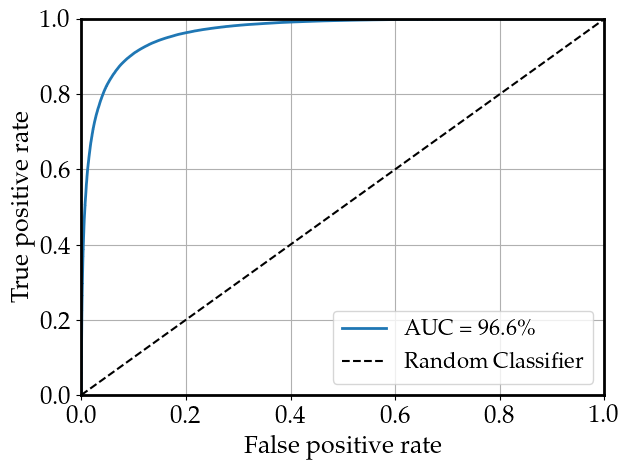

In [95]:
# plot ROC curve
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc(fpr,tpr)*100:.1f}\%")
plt.plot(np.linspace(0,1),np.linspace(0,1),color='k',ls='--',label = 'Random Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('plots/ROC_MLP_subjettiness_and_impact_parameter.pdf')
plt.show()

In [96]:
fig = make_ks_plot(y_train.to_numpy()[:,0], predict_array_train[:,0],
                   y_test.to_numpy()[:,0], predict_array_test[:,0])
fig.savefig('plots/KS_MLP_subjettiness_and_impact_parameter.pdf')

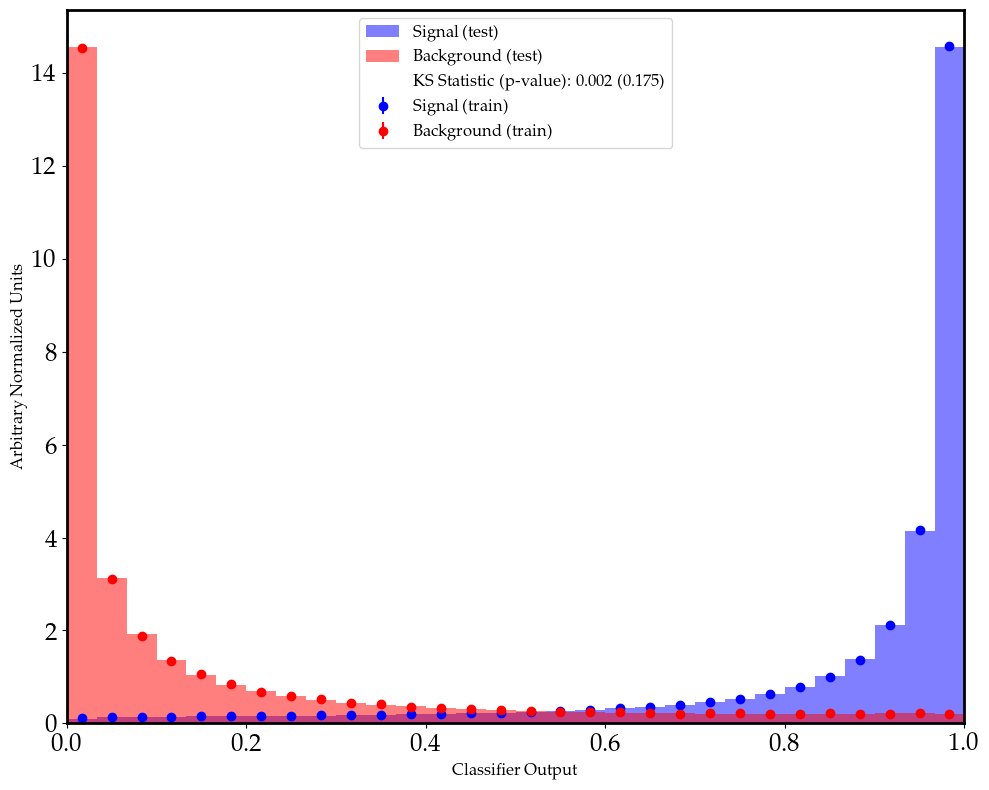

In [97]:
fig

In [54]:
bdt = XGBClassifier(booster='gbtree')

In [55]:
%%time
bdt.fit(X_train_final.to_numpy(), y_train.to_numpy())

CPU times: user 1h 6min 31s, sys: 1min 33s, total: 1h 8min 5s
Wall time: 7min 41s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [56]:
print(bdt.score(X_train_final.to_numpy(), y_train.to_numpy()))
print(bdt.score(X_test_final.to_numpy(), y_test.to_numpy()))

0.9118538032983101
0.9095347772210549


In [57]:
predict_array_train = bdt.predict_proba(X_train_final)
predict_array_test = bdt.predict_proba(X_test_final)
fpr, tpr, threshold = roc_curve(y_test.to_numpy()[:,0], predict_array_test[:,0])

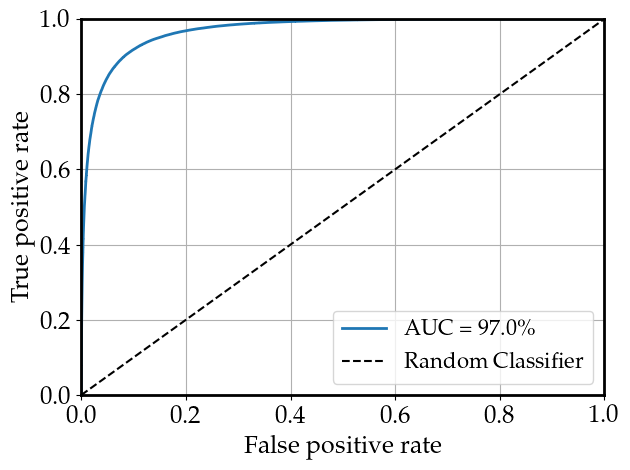

In [58]:
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc(fpr,tpr)*100:.1f}\%")
plt.plot(np.linspace(0,1),np.linspace(0,1),color='k',ls='--',label = 'Random Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('plots/ROC_BDT_subjettiness_and_impact_parameter.pdf')
plt.show()

In [59]:
fig = make_ks_plot(y_train.to_numpy()[:,0], predict_array_train[:,0],
                   y_test.to_numpy()[:,0], predict_array_test[:,0])
fig.savefig('plots/KS_BDT_subjettiness_and_impact_parameter.pdf')

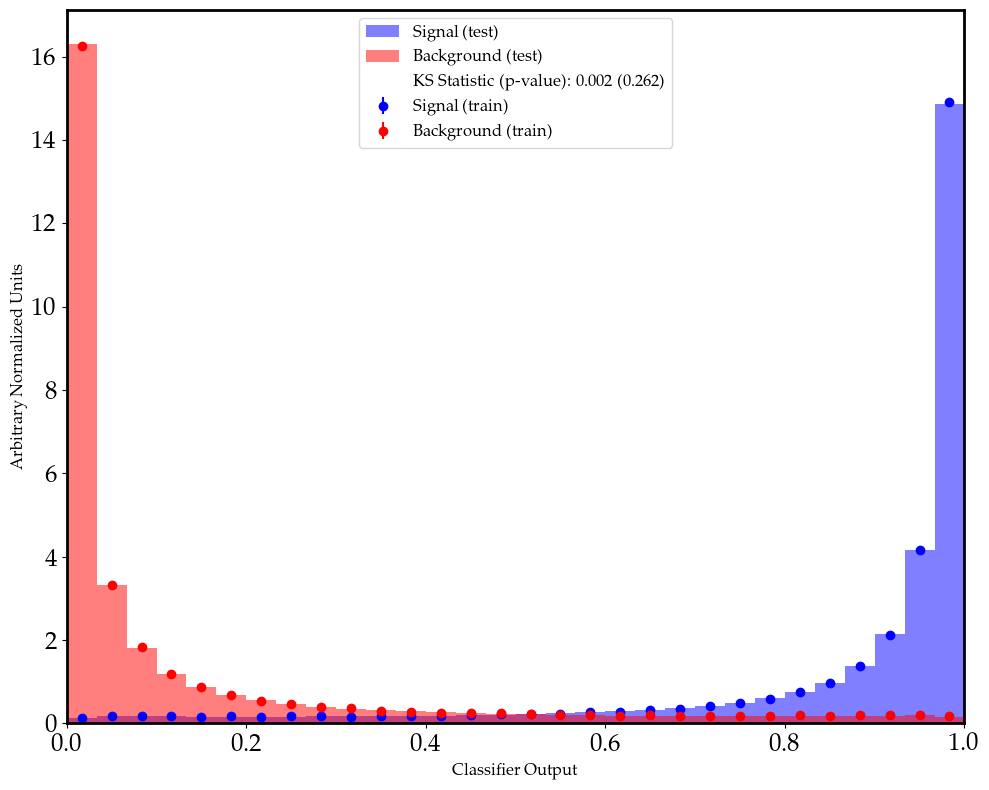

In [60]:
fig

In [61]:
fisher = LinearDiscriminantAnalysis()

In [63]:
%%time
fisher.fit(X_train_final.to_numpy(), y_train.to_numpy()[:,0])

CPU times: user 12.7 s, sys: 2.2 s, total: 14.9 s
Wall time: 7.39 s


LinearDiscriminantAnalysis()

In [64]:
print(fisher.score(X_train_final.to_numpy(), y_train.to_numpy()[:,0]))
print(fisher.score(X_test_final.to_numpy(), y_test.to_numpy()[:,0]))

0.8500563403822845
0.8512090763787871


In [65]:
predict_array_train = fisher.predict_proba(X_train_final)
predict_array_test = fisher.predict_proba(X_test_final)
fpr, tpr, threshold = roc_curve(y_test.to_numpy()[:,0], predict_array_test[:,1])

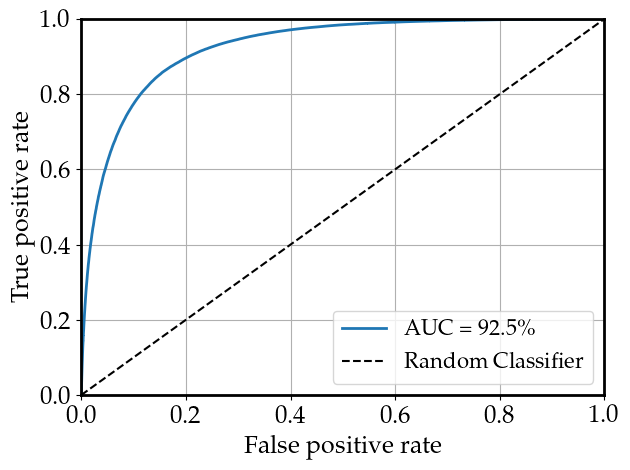

In [66]:
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc(fpr,tpr)*100:.1f}\%")
plt.plot(np.linspace(0,1),np.linspace(0,1),color='k',ls='--',label = 'Random Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('plots/ROC_LDA_subjettiness_and_impact_parameter.pdf')
plt.show()

In [67]:
fig = make_ks_plot(y_train.to_numpy()[:,0], predict_array_train[:,1],
                   y_test.to_numpy()[:,0], predict_array_test[:,1])
fig.savefig('plots/KS_LDA_subjettiness_and_impact_parameter.pdf')

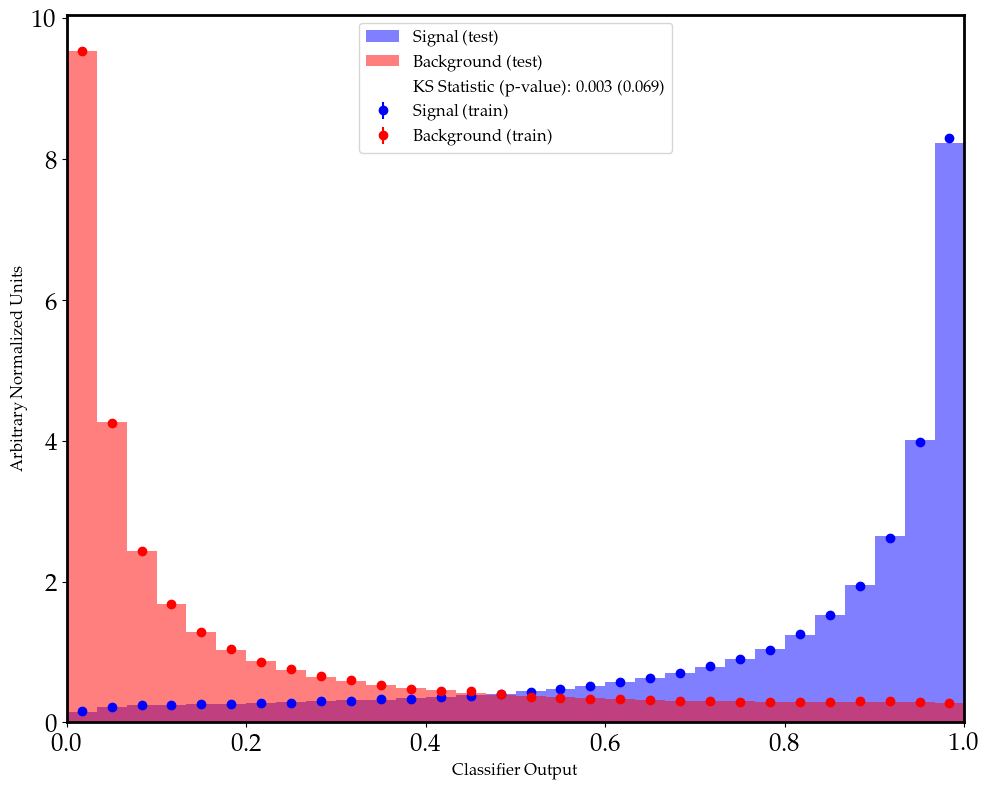

In [68]:
fig